In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [93]:
df = pd.read_csv("../out/generalization/4uc51x21.csv")
df["cardinality_ratio"] = df["cardinality_truth"] / df["cardinality_output"]
df.head()

,simulation_idx,step_idx,mse,cardinality_target,cardinality_output,cardinality_truth,scale,cardinality_ratio
0,0,0,0.000039,11.558531,3.981616,12,1,3.013852
1,0,1,0.000037,12.991114,8.018620,14,1,1.745936
2,0,2,0.000032,11.786787,4.704407,12,1,2.550800
3,0,3,0.000034,10.903723,4.855875,11,1,2.265297
4,0,4,0.000025,9.963219,2.870759,10,1,3.483400


In [94]:
df.groupby("scale").mean()

,simulation_idx,step_idx,mse,cardinality_target,cardinality_output,cardinality_truth,cardinality_ratio
scale,,,,,,,
1,49.5,49.5,0.000025,10.021014,3.681034,10.1098,2.745201


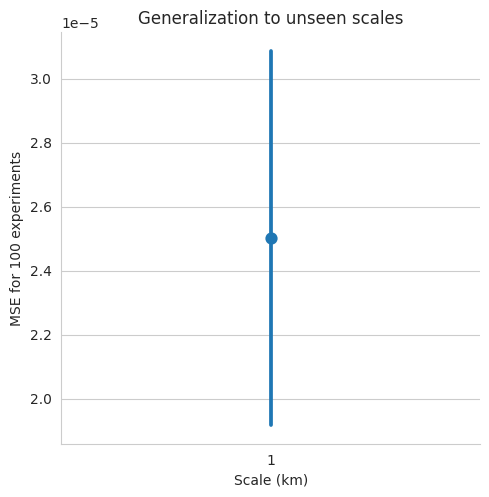

In [95]:
data = df.groupby(by=["scale", "simulation_idx"]).mean().drop(columns=["step_idx"]).reset_index()
sns.catplot(data=data, x="scale", y="mse", kind="point", errorbar=("sd", 1))
plt.ylabel("MSE for 100 experiments")
plt.xlabel("Scale (km)")
plt.title("Generalization to unseen scales")
plt.show()

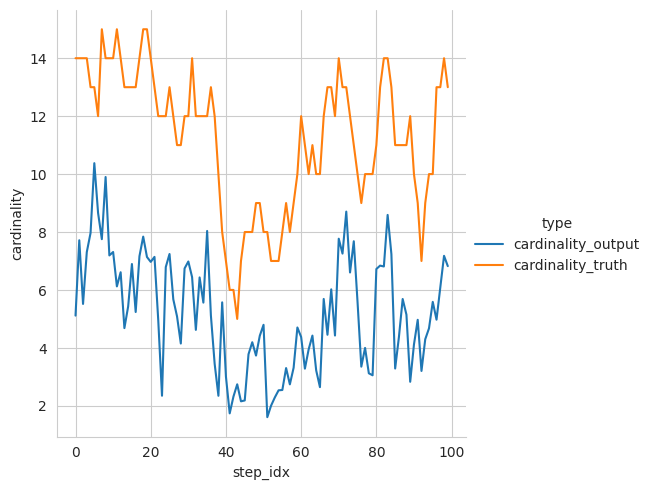

In [96]:
data = df.query("scale == 1 and simulation_idx == 30").melt(id_vars=["step_idx"], value_vars=["cardinality_output", "cardinality_truth"], var_name="type", value_name="cardinality")
sns.relplot(data=data, x="step_idx", y="cardinality", hue="type", kind="line")

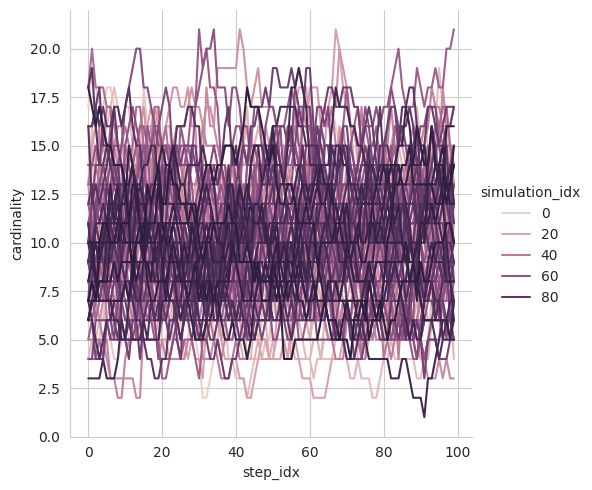

In [97]:
data = df.query("scale == 1").melt(id_vars=["step_idx", "simulation_idx"], value_vars=["cardinality_truth"], var_name="type", value_name="cardinality")
sns.relplot(data=data, x="step_idx", y="cardinality", hue="simulation_idx", kind="line")